## Data

In [1]:
import os
import glob
import io
import pandas as pd
from sklearn.utils import shuffle

In [2]:
path = "/home/elias/Documents/Data/news_categories/bbc-fulltext/bbc/train"
examples = []
for i,label in enumerate(['business','entertainment','politics','sport','tech']):
    for fname in glob.iglob(os.path.join(path, label, '*.txt')):
        try:
            with io.open(fname, 'r', encoding="utf-8") as f:
                text = f.read()
            examples.append([i,text])
        except:
            print("error reading file ", fname)
            continue
path = "/home/elias/Documents/Data/news_categories/bbc-fulltext/bbc/test"
for i,label in enumerate(['business','entertainment','politics','sport','tech']):
    for fname in glob.iglob(os.path.join(path, label, '*.txt')):
        try:
            with io.open(fname, 'r', encoding="utf-8") as f:
                text = f.read()
            examples.append([i,text])
        except:
            print("error reading file ", fname)
            continue

error reading file  /home/elias/Documents/Data/news_categories/bbc-fulltext/bbc/train/sport/199.txt


In [3]:
df = shuffle(pd.DataFrame(examples,columns=['label','text']))

In [4]:
df = df.reset_index(drop=True)

In [5]:
df.head(3)

,label,text
0,0,Weak dollar hits Reuters\n\nRevenues at media ...
1,1,Little Britain vies for TV trophy\n\nBBC hits ...
2,0,Air passengers win new EU rights\n\nAir passen...


In [6]:
df.to_pickle('bbc_data_df')

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from newspaper import Article
from fastai import *
from fastai.text import *

- 0 -> Business
- 1 -> Entertainment
- 2 -> Politics
- 3 -> Sport
- 4 -> Tech

In [2]:
import fastai
fastai.__version__

'1.0.53.dev0'

## Data processing

In [3]:
df = pd.read_pickle('bbc_data_df')

In [4]:
df = shuffle(df).reset_index(drop=True)

In [5]:
df.head(3)

,label,text
0,1,West End to honour finest shows\n\nThe West En...
1,1,De Niro film leads US box office\n\nFilm star ...
2,3,Relay squad thrilled with honours\n\nJason Gar...


In [6]:
train_pro = 0.9

train_df = df[:round(len(df)*train_pro)]
train_df = train_df.reset_index(drop=True)
valid_df = df[round(len(df)*train_pro):]
valid_df = valid_df.reset_index(drop=True)

In [7]:
len(train_df),len(valid_df)

(1642, 182)

In [8]:
train_df.head(3)

,label,text
0,1,West End to honour finest shows\n\nThe West En...
1,1,De Niro film leads US box office\n\nFilm star ...
2,3,Relay squad thrilled with honours\n\nJason Gar...


In [9]:
valid_df.head(3)

,label,text
0,4,Tough rules for ringtone sellers\n\nFirms that...
1,0,China now top trader with Japan\n\nChina overt...
2,3,Minister digs in over doping row\n\nThe Belgia...


In [10]:
train_df['label'].value_counts()

0    459
3    358
2    292
4    276
1    257
Name: label, dtype: int64

In [11]:
valid_df['label'].value_counts()

3    52
0    51
1    29
4    25
2    25
Name: label, dtype: int64

In [12]:
data_lm = TextLMDataBunch.from_df('./', train_df=train_df, valid_df=valid_df)

In [13]:
data_lm.show_batch()

idx,text
0,"theatre . xxmaj it is competing against xxmaj sweeney xxmaj todd and a xxmaj funny xxmaj thing xxmaj happened on the xxmaj way to the xxmaj forum for the award . xxmaj the xxmaj goat or xxmaj who is xxmaj sylvia ? by xxmaj edward xxmaj xxunk , xxmaj the xxmaj xxunk by xxmaj martin xxunk and xxmaj alan xxmaj bennett 's xxmaj the xxmaj history xxmaj boys are shortlisted"
1,"pc sales have risen by a fifth in each of the past two years , but are now growing more slowly . xxmaj the company is still by far the biggest player in xxmaj china , with more than a quarter of the market . xxmaj but xxmaj western firms such as xxmaj dell and xxmaj hewlett - xxmaj packard are also mounting a more solid fight for market share"
2,"xxmaj however , xxmaj matt xxmaj williams , a fund manager at xxmaj xxunk xxmaj xxunk said taking the stake "" is definitely a precursor to a takeover "" . \n xxbos xxmaj guantanamo four free in weeks \n \n xxmaj all four xxmaj britons held by the xxup us in xxmaj guantanamo xxmaj bay will be returned to the xxup uk within weeks , xxmaj foreign xxmaj"
3,xxmaj wilson and xxmaj dick xxmaj king - xxmaj smith . \n xxbos xxmaj xxunk handed potential xxmaj man xxmaj utd tie \n \n xxmaj brentford face a home tie against holders xxmaj manchester xxmaj united in the xxup fa xxmaj cup sixth round if they can come through their replay against xxmaj southampton . \n \n xxmaj the xxmaj league xxmaj one side held the xxmaj
4,cost of these recycled handsets means they can have a very useful second life in poorer nations . xxmaj but the xxmaj forum found that more needed to be done to collect old phones rather than let them rot in landfill sites . \n \n xxmaj the report reveals that approximately 15 million mobile phones go out of use every year in the xxup uk . xxmaj of the


In [14]:
#data_lm.save('tmp_lm')

In [15]:
#data_lm = TextClasDataBunch.load('./','tmp_lm')

## Language model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


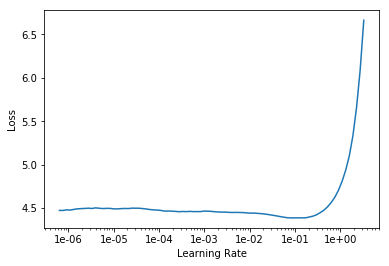

In [14]:
learner = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.5)
learner.lr_find()
learner.recorder.plot()

In [15]:
learner.fit_one_cycle(1,1e-2)
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,3.982805,3.531828,0.348337,00:20


In [16]:
learner.fit_one_cycle(1,1e-3)
learner.save_encoder('fine_enc')

epoch,train_loss,valid_loss,accuracy,time
0,3.610245,3.407227,0.364196,00:24


## Classifier

In [17]:
data_clas = TextClasDataBunch.from_df('./',train_df=train_df,valid_df=valid_df,vocab=data_lm.train_ds.vocab,bs=32)

In [20]:
data_clas.export("./export.pkl")

In [21]:
classifier = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
classifier.load_encoder('fine_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


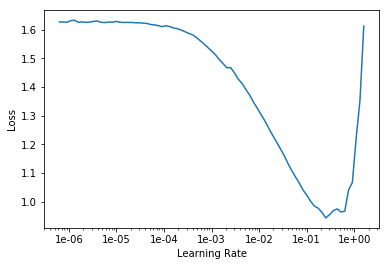

In [22]:
classifier.lr_find()
classifier.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.496846,0.178967,0.928571,00:13
1,0.276694,0.123213,0.945055,00:13


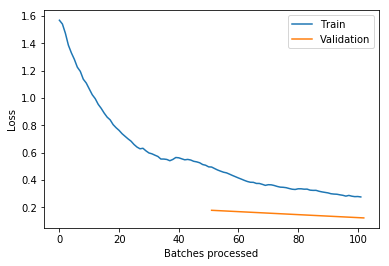

In [23]:
classifier.fit_one_cycle(2,2e-2,moms=(0.8,0.7))
classifier.recorder.plot_losses()

In [24]:
classifier.save('./model')

## Test

In [3]:
data_clas = TextClasDataBunch.load_empty('./')

In [4]:
classifier = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
_ = classifier.load('./model')

In [114]:
url = "https://www.bbc.com/sport/cricket/48582537"

In [121]:
article = Article(url)
article.download()
article.parse()
article_text = article.text

In [116]:
article_text = "Yuvraj Singh: India all-rounder retires from international cricket"

In [117]:
label, number, values = classifier.predict(article_text,own=False)

In [118]:
values.numpy()

array([0.059459, 0.159129, 0.012193, 0.763894, 0.005325], dtype=float32)

In [119]:
label

Category 3

In [120]:
labels = ['business','entertainment','politics','sport','tech']
for i,v in enumerate(values.numpy()):
    print(labels[i],"-",v)

business - 0.059459127
entertainment - 0.15912879
politics - 0.012192723
sport - 0.7638942
tech - 0.005325197


